## Cluster Technique Search and Accuracy Test

Adding in length it matters. Go back at into preprocessing and instead of taking the first value we need to group by and take the sum of each group instead. This is what causes the miss alignment in precursor statistics for the surge in that sequence. Could be affecting our clustering data. 

Checklist
- run with standard scaler instead
- add in implementation of bin scoring 
- check other cluster scoring methodologies instead of silhoutte 
- check other clustering options
- maybe do a grid search of each indivdual methodology instead 

No quantile standard scalar is much better

In [18]:
import pandas as pd
# from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
import sklearn.metrics
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import datetime

#SPECIFIED CLUSTER DISCOVERY
# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV
# from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, Birch
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering,\
MeanShift, AffinityPropagation, DBSCAN, OPTICS, Birch
from sklearn.metrics import silhouette_score

In [19]:
# BIN TECHNIQUE
# load pipeline 1 csv and prep for clustering
m2_pipeline = pd.read_csv('pipeline1.csv')
# change is surge price rate of change per observation, change.1 is precursor
# sum_change is surge sum_change per surge, and surge_area is surge alone

In [20]:
m2_pipeline.iloc[0,:]

group                                           2
time                              1660221654244.0
s_MP                                         30.0
change                                  -0.000533
type                                    precursor
p_MP                                        29.98
precursor_buy_cap_pct_change            -0.000044
precursor_ask_cap_pct_change            -0.000004
precursor_bid_vol_pct_change            -0.000017
precursor_ask_vol_pct_change            -0.000351
length                                          6
sum_change                               -0.00501
max_surge_mp                                 30.0
min_surge_mp                                 30.0
max_precursor_mp                            29.98
min_precursor_mp                            29.85
area                                    -0.030057
surge_targets_met_pct                   -0.066667
group.1                                         3
time.1                            1660221833233.0


In [21]:
keepable = ['precursor_buy_cap_pct_change', 
            'precursor_ask_cap_pct_change',
            'precursor_bid_vol_pct_change', 
            'precursor_ask_vol_pct_change',
            'sum_change',
            'length',
            'surge_targets_met_pct']
x = m2_pipeline[['surge_targets_met_pct']].values.astype(float)
m2_pipeline = m2_pipeline[keepable]

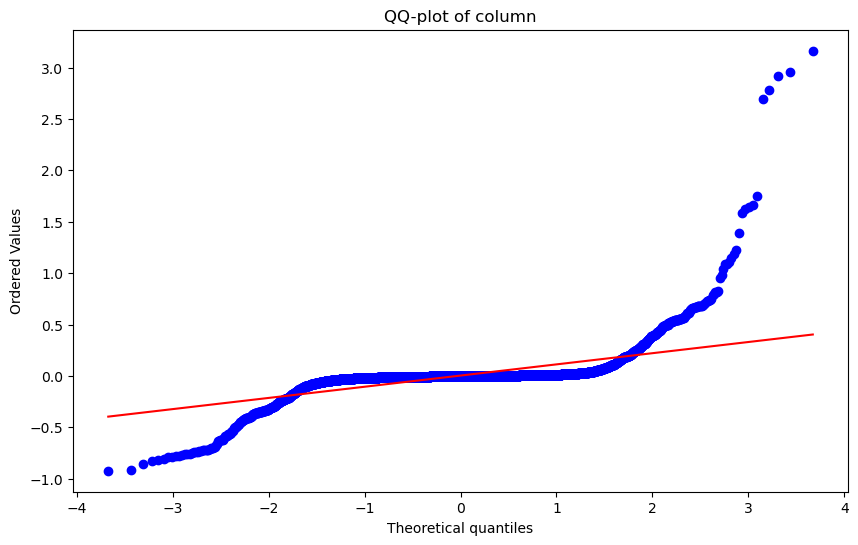

In [22]:
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
stats.probplot(m2_pipeline['precursor_buy_cap_pct_change'], dist="norm", plot=plt)
plt.title('QQ-plot of column')
plt.show()


In [23]:
bins = [
    m2_pipeline['surge_targets_met_pct'].min() -1,  # Min value
    -4/3*2,  # -4 to 0 divided into three equal parts
    -4/3,  # Second bin edge for negative values
    0,  # Zero separating negative and positive values
    0.25, 0.5, 0.75, 1,  # Four bins between 0 and 1
    2,  # One bin between 1 and 2
    m2_pipeline['surge_targets_met_pct'].max() + 1]

In [24]:
bins

[-4.24232081911261,
 -2.6666666666666665,
 -1.3333333333333333,
 0,
 0.25,
 0.5,
 0.75,
 1,
 2,
 5.322377307519139]

In [25]:
m2_pipeline['label'] = pd.cut(m2_pipeline['surge_targets_met_pct'], bins=bins, labels=list(range(1, len(bins))))

In [26]:
m2_pipeline

,precursor_buy_cap_pct_change,precursor_ask_cap_pct_change,precursor_bid_vol_pct_change,precursor_ask_vol_pct_change,sum_change,length,surge_targets_met_pct,label
0,-0.000044,-0.000004,-0.000017,-0.000351,-5.009518e-03,6,-0.066667,3
1,-0.002358,-0.000002,-0.000818,-0.000333,1.345640e-04,1,0.100469,4
2,-0.001354,-0.000017,-0.000446,-0.001967,-3.410602e-03,3,0.133779,4
3,-0.000514,0.000017,-0.000278,0.001923,8.855895e-07,2,-0.033467,3
4,0.014278,0.000034,0.006498,0.008866,-1.377036e-02,7,0.167224,4
...,...,...,...,...,...,...,...,...
5725,-0.007939,-0.000315,-0.001930,-0.000743,-2.389645e-03,2,-0.099502,3
5726,-0.604637,-0.990184,0.384741,-0.122234,-3.020852e-01,5,0.000000,3
5727,-0.001037,-0.000074,-0.000258,-0.000349,-4.980070e-04,5,0.099800,4
5728,0.010895,-0.000219,0.002650,-0.000977,-9.952165e-04,18,0.000000,3


In [27]:
m2_pipeline.to_csv('binned_pipeline.csv')

In [28]:
global_test_results = [] #capture each test summary here, make df on this later
profitability_analytics =[] #capture the value of each cluster, bin x price avg

In [29]:
def get_cluster_profit(cluster):
    print(cluster) #method, cluster count, silhouette score
    # for the dataframe m2_pipeline, group by 'cluster' then 'bin', multiply bin as number by the average price by bin

### standardize all features pre train/test

In [30]:
m2_pipeline = m2_pipeline.dropna()

# Splitting the dataframe into features and labels
X = m2_pipeline[['precursor_buy_cap_pct_change', 'precursor_ask_cap_pct_change','precursor_bid_vol_pct_change',
                'precursor_ask_vol_pct_change','sum_change', 'length']]
y = m2_pipeline['label']

# Performing the test/train split and standardization
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#from sklearn.preprocessing import QuantileTransformer
#qt = QuantileTransformer(output_distribution='normal', random_state=0)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_train_scaled = pd.DataFrame(qt.fit_transform(X_train), columns=X_train.columns)
#X_test_scaled = pd.DataFrame(qt.transform(X_test), columns=X_test.columns)

In [31]:
print(m2_pipeline.isna().sum(axis=1).astype(bool).sum())

0


In [32]:
def silhouette_scorer(estimator, X, y=None):
    labels = estimator.fit_predict(X)
    score = silhouette_score(X, labels)
    return score

In [33]:
clf = KMeans(n_clusters = 6)
clf.fit(X_train_scaled)
silhouette_scorer(clf, X_train_scaled, y=None)

0.5479952462990493

In [34]:
# good till here work from here 
#def silhouette_scorer(estimator, X, y=None):
#    score = silhouette_score(X, estimator.labels_)
#    return score
# Defining the parameter grid for GridSearchCV
param_grid = {'n_clusters': [2,3,4,5,6,7,8,9,10]}  #'algorithm': ['auto', 'full', 'elkan']

clustering_models = [
    ('KMeans', KMeans()),
    #('SpectralClustering', SpectralClustering(eigen_solver=None, n_components=None, random_state=42, n_init=10, gamma=1.0, affinity='rbf',\
          #            n_neighbors=10, eigen_tol='auto', assign_labels='kmeans', degree=3, coef0=1, kernel_params=None, n_jobs=None, verbose=False)),
    ('Birch', Birch()),
    ('Hierarchical',AgglomerativeClustering())]
# Performing GridSearchCV for each clustering model
for model_name, model in clustering_models:
    grid_search = GridSearchCV(model, param_grid, scoring=silhouette_scorer)
    grid_search.fit(X_train_scaled)
    # Evaluating the best model based on silhouette score
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    print(f'{model_name}:')
    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Silhouette score (train): {best_score:.4f}')
    best_params = grid_search.best_params_
    big_dict = grid_search.cv_results_
    pkg = {"algo": model_name, "best_params": grid_search.best_params_,
        "best_estimator": grid_search.best_estimator_,
        "best_score": best_score, "all_results": big_dict} 
    # # Add the cluster label as a new column
    #method_df = X_train_scaled
    #method_df['label'] = y_train
    #method_df['cluster_label'] = best_model.labels_

    #now = datetime.datetime.now()
    #print("Current date and time: ")
    #print(now.strftime("%Y-%m-%d %H:%M:%S"))
    #run_time = now.strftime("%Y-%m-%d %H:%M:%S")
    #file_name = 'clustered/'+ 'clustered_'+ model_name+' _'+ run_time+ '.csv'
    #print(file_name)
    #method_df.to_csv(file_name)
    # print(pkg)
    global_test_results.append(pkg)

KMeans:
Best parameters: {'n_clusters': 2}
Silhouette score (train): 0.9057
Birch:
Best parameters: {'n_clusters': 2}
Silhouette score (train): 0.9001
Hierarchical:
Best parameters: {'n_clusters': 2}
Silhouette score (train): 0.8847


In [35]:
clustering_models = [
    ('Meanshift',  MeanShift( bandwidth=None, seeds=None, bin_seeding=False, min_bin_freq=1, cluster_all=True, n_jobs=None, max_iter=300)),
    ('AffinityPropagation', AffinityPropagation( damping=0.5, max_iter=200, convergence_iter=15, copy=True, preference=None, affinity='euclidean', verbose=False, random_state=42)),
    ('DBSCAN', DBSCAN(eps=0.5, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)),
    ('OPTICS', OPTICS( min_samples=5, max_eps=3, metric='minkowski', p=2, metric_params=None, cluster_method='xi', eps=None, xi=0.05, predecessor_correction=True, min_cluster_size=None, algorithm='auto', leaf_size=30, n_jobs=None))]

In [36]:

param_grid = {}  #'algorithm': ['auto', 'full', 'elkan']
for model_name, model in clustering_models:
    grid_search = GridSearchCV(model, param_grid, scoring=silhouette_scorer)
    grid_search.fit(X_train_scaled)
    # Evaluating the best model based on silhouette score
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    print(f'{model_name}:')
    # print(f'Best parameters: {grid_search.best_params_}')
    print(f'Silhouette score (train): {best_score:.4f}')
    print(f'Silhouette score (test): {best_score:.4f}')
    big_dict = grid_search.cv_results_
    pkg = {"algo":model_name, "best_params":grid_search.best_params_, "best_estimator":grid_search.best_estimator_,\
            "best_score":best_score, "all_results":big_dict}
    # print(pkg)
    global_test_results.append(pkg)

Meanshift:
Silhouette score (train): 0.4849
Silhouette score (test): 0.4849


/Users/stefanbund/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:236: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/Users/stefanbund/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:236: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/Users/stefanbund/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:236: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/Users/stefanbund/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:236: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/Users/stefanbund/anaconda3/lib/python3.

AffinityPropagation:
Silhouette score (train): 0.2896
Silhouette score (test): 0.2896
DBSCAN:
Silhouette score (train): 0.5028
Silhouette score (test): 0.5028
OPTICS:
Silhouette score (train): -0.4811
Silhouette score (test): -0.4811


Left off here work on cluster accuracy now

In [37]:
# from sklearn.cluster import SpectralClustering
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_clusters': [2,3,4,5,6,7,8,9,10],
#     'affinity': ['nearest_neighbors', 'rbf'],
#     'gamma': [0.1, 1.0, 10.0]
# }
# def silhouette_scorer(estimator, X, y=None):
#     labels = estimator.fit_predict(X)
#     score = silhouette_score(X, labels)
#     return score
# # ('SpectralClustering', SpectralClustering(eigen_solver=None, n_components=None, random_state=42, n_init=10, gamma=1.0, affinity='rbf',\
#     #                   n_neighbors=10, eigen_tol='auto', assign_labels='kmeans', degree=3, coef0=1, kernel_params=None, n_jobs=None, verbose=False)),
# clustering = SpectralClustering(eigen_solver=None, n_components=None, random_state=42, n_init=10, gamma=1.0, affinity='rbf',\
#                       n_neighbors=10, eigen_tol='auto', assign_labels='kmeans', degree=3, coef0=1, kernel_params=None, n_jobs=None, verbose=False)
# grid_search = GridSearchCV(clustering, param_grid, scoring=silhouette_scorer)
# grid_search.fit(X_train_scaled, y_train)
# # Evaluating the best model based on silhouette score
# best_model = grid_search.best_estimator_
# best_score = grid_search.best_score_
# print(f'{model_name}:')
# # print(f'Best parameters: {grid_search.best_params_}')
# print(f'Silhouette score (train): {best_score:.4f}')
# print(f'Silhouette score (test): {best_score:.4f}')
# big_dict = grid_search.cv_results_
# pkg = {"algo":model_name, "best_params":grid_search.best_params_, "best_estimator":grid_search.best_estimator_,\
#         "best_score":best_score, "all_results":big_dict}
# # print(pkg)
# global_test_results.append(pkg)

## explore clustering methods by profitability

apply the cluster id to the dataframe, group by, then summarize value by bin x price range

## explore top results by cluster quality scoring

use silhouette viz

then davies

then kolmogorov

In [38]:
result_df = pd.DataFrame(global_test_results)
result_df

,algo,best_params,best_estimator,best_score,all_results
0,KMeans,{'n_clusters': 2},KMeans(n_clusters=2),0.905724,"{'mean_fit_time': [0.29558796882629396, 0.3649..."
1,Birch,{'n_clusters': 2},Birch(n_clusters=2),0.900053,"{'mean_fit_time': [0.08960280418395997, 0.0851..."
2,Hierarchical,{'n_clusters': 2},AgglomerativeClustering(),0.884691,"{'mean_fit_time': [0.2784595966339111, 0.27024..."
3,Meanshift,{},MeanShift(),0.484935,"{'mean_fit_time': [4.995885562896729], 'std_fi..."
4,AffinityPropagation,{},AffinityPropagation(random_state=42),0.289580,"{'mean_fit_time': [18.530214691162108], 'std_f..."
5,DBSCAN,{},DBSCAN(),0.502811,"{'mean_fit_time': [0.20637307167053223], 'std_..."
6,OPTICS,{},OPTICS(max_eps=3),-0.481111,"{'mean_fit_time': [0.7547399520874023], 'std_f..."


In [39]:
#charting silhouettes
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score

# Calculate the silhouette scores for each sample
silhouette_values = silhouette_samples(X, labels)

# Calculate the average silhouette score
average_score = silhouette_score(X, labels)

# Plot the silhouette chart
fig, ax = plt.subplots()
y_lower = 10

for i in range(n_clusters):
    # Aggregate the silhouette scores for samples in cluster i and sort them
    ith_cluster_silhouette_values = silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    # Fill the silhouette chart with the corresponding color
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

    # Label each cluster with its silhouette score
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10

ax.set_xlabel("Silhouette coefficient values")
ax.set_ylabel("Cluster label")

# The vertical line indicates the average silhouette score
ax.axvline(x=average_score, color="red", linestyle="--")

plt.show()


NameError: name 'labels' is not defined

## retry spectral clustering, outside GridSearchCV

In [ ]:
#use best model:
from sklearn.model_selection import train_test_split
from sklearn.cluster import SpectralClustering
from sklearn.metrics import accuracy_score
X = m2_pipeline.drop(columns=['bin'])
y = m2_pipeline['bin']
# Splitting the dataset into train and test sets

#USE STANDARD SCALING ONCE YOU DIVDE TEST AND TRAIN NOT BEFORE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating an instance of SpectralClustering
model = SpectralClustering(n_clusters=7)

# Fitting the model to the training data
model.fit_predict(X_train)

# Predicting labels for the testing data
y_pred = model.predict(X_test)

# Calculating the accuracy score
accuracy = accuracy_score(y_test, y_pred)
